In [ ]:
!git clone https://github.com/WouterBant/GEVit-DL2-Project.git

In [ ]:
%cd GEVit-DL2-Project/

In [1]:
%load_ext autoreaload
%autoreload 2

In [2]:
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)

In [3]:
import torch
from g_selfatt.utils import num_params
import torchvision
from datasets import MNIST_rot
import matplotlib.pyplot as plt
import torch.nn as nn

/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/wouter/miniconda3/envs/dl2023/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_

In [22]:
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
train_set = MNIST_rot(root="../data", stage="train", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=1,
    shuffle=True,
    num_workers=4,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

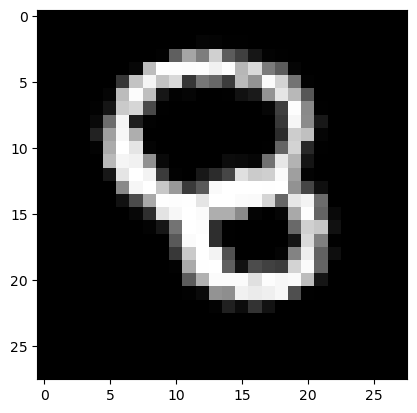

In [23]:
data = iter(train_loader)
img, _ = next(data)
plt.imshow(img.squeeze(), cmap="gray")

In [27]:
# https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x
    
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x, output_cls=False):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        if output_cls:
            return cls

        out = self.mlp_head(cls)
        return out
    
model = VisionTransformer(embed_dim=128,
                          hidden_dim=256,
                          num_heads=4,
                          num_layers=4,
                          patch_size=4,
                          num_channels=1,
                          num_patches=49,
                          num_classes=2,
                          dropout=0.1)

In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [33]:
print(f"Number of parameters in the model: {num_params(model)}")

Number of parameters in the model: 539138


In [32]:
model.train()
for epoch in range(1):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.zero_grad()
        print(loss.item())

1.4407010078430176
0.28424331545829773
1.5984238386154175
0.299527108669281
0.3241058588027954
0.36222898960113525
1.1786813735961914
0.31319960951805115
1.025673747062683
1.5505657196044922
1.6234663724899292
0.3356245458126068
0.16443021595478058
0.3312017321586609
1.3636595010757446
1.2089016437530518
1.5004746913909912
1.2650359869003296
1.0155186653137207
0.28767290711402893
0.43518444895744324
1.0712440013885498
0.8038077354431152
0.30074238777160645
0.3327938914299011
0.25761550664901733
0.2956368327140808
1.0267773866653442
0.6181232333183289
1.9014256000518799
1.1457929611206055
1.5774121284484863
1.4608534574508667
1.2568943500518799
0.20373199880123138
1.2985045909881592
1.9269894361495972
1.4188138246536255
0.1796187460422516
0.2570554316043854
1.43245530128479
1.4208548069000244
0.32932767271995544
0.32777222990989685
1.5646058320999146
1.4716202020645142
1.329795241355896
0.3724038600921631
0.33363962173461914
0.3446652889251709
0.29665741324424744
0.19485114514827728
1.5